<a href="https://colab.research.google.com/github/danielbauer1979/ML_656/blob/main/Module9_HousePriceExample.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [99]:
import numpy as np 
import matplotlib.pyplot as plt  
import pandas as pd 
import seaborn as sns
import graphviz
import pydot
from io import StringIO  

from sklearn.preprocessing import scale
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier, export_graphviz
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier,BaggingRegressor, RandomForestRegressor, GradientBoostingRegressor
import sklearn.metrics as metrics

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# HOUSE PRICE EXAMPLE

# Get data

In [2]:
!git clone https://github.com/danielbauer1979/ML_656.git

Cloning into 'ML_656'...
remote: Enumerating objects: 104, done.
remote: Counting objects: 100% (104/104), done.
remote: Compressing objects: 100% (103/103), done.
remote: Total 104 (delta 45), reused 0 (delta 0), pack-reused 0
Receiving objects: 100% (104/104), 21.66 MiB | 4.03 MiB/s, done.
Resolving deltas: 100% (45/45), done.


In [63]:
house = pd.read_csv('ML_656/HouseData.csv')
house.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,...,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,...,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,...,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,...,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,...,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,...,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


## Prep Data

In [ ]:
pd.set_option("display.max_rows", None)
house.isnull().sum(axis = 0)

In [66]:
house = house.drop(columns=['Id','LotFrontage','Alley', 'BsmtQual', 'BsmtCond','BsmtExposure','BsmtFinType1','BsmtFinType2','FireplaceQu','GarageType','GarageYrBlt','GarageFinish','GarageQual','GarageCond','PoolQC','Fence','MiscFeature'])

,MSSubClass,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
count,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1452.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000
mean,56.897260,10516.828082,6.099315,5.575342,1971.267808,1984.865753,103.685262,443.639726,46.549315,567.240411,1057.429452,1162.626712,346.992466,5.844521,1515.463699,0.425342,0.057534,1.565068,0.382877,2.866438,1.046575,6.517808,0.613014,1.767123,472.980137,94.244521,46.660274,21.954110,3.409589,15.060959,2.758904,43.489041,6.321918,2007.815753,180921.195890
std,42.300571,9981.264932,1.382997,1.112799,30.202904,20.645407,181.066207,456.098091,161.319273,441.866955,438.705324,386.587738,436.528436,48.623081,525.480383,0.518911,0.238753,0.550916,0.502885,0.815778,0.220338,1.625393,0.644666,0.747315,213.804841,125.338794,66.256028,61.119149,29.317331,55.757415,40.177307,496.123024,2.703626,1.328095,79442.502883
min,20.000000,1300.000000,1.000000,1.000000,1872.000000,1950.000000,0.000000,0.000000,0.000000,0.000000,0.000000,334.000000,0.000000,0.000000,334.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000,34900.000000
25%,20.000000,7553.500000,5.000000,5.000000,1954.000000,1967.000000,0.000000,0.000000,0.000000,223.000000,795.750000,882.000000,0.000000,0.000000,1129.500000,0.000000,0.000000,1.000000,0.000000,2.000000,1.000000,5.000000,0.000000,1.000000,334.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,2007.000000,129975.000000
50%,50.000000,9478.500000,6.000000,5.000000,1973.000000,1994.000000,0.000000,383.500000,0.000000,477.500000,991.500000,1087.000000,0.000000,0.000000,1464.000000,0.000000,0.000000,2.000000,0.000000,3.000000,1.000000,6.000000,1.000000,2.000000,480.000000,0.000000,25.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000,163000.000000
75%,70.000000,11601.500000,7.000000,6.000000,2000.000000,2004.000000,166.000000,712.250000,0.000000,808.000000,1298.250000,1391.250000,728.000000,0.000000,1776.750000,1.000000,0.000000,2.000000,1.000000,3.000000,1.000000,7.000000,1.000000,2.000000,576.000000,168.000000,68.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000,214000.000000
max,190.000000,215245.000000,10.000000,9.000000,2010.000000,2010.000000,1600.000000,5644.000000,1474.000000,2336.000000,6110.000000,4692.000000,2065.000000,572.000000,5642.000000,3.000000,2.000000,3.000000,2.000000,8.000000,3.000000,14.000000,3.000000,4.000000,1418.000000,857.000000,547.000000,552.000000,508.000000,480.000000,738.000000,15500.000000,12.000000,2010.000000,755000.000000


In [ ]:
house = house.dropna()
house.info()

In [80]:
col_types = house.columns.to_series().groupby(house.dtypes).groups
numerics = list(house.select_dtypes(include=['int64']).columns)
factors = list(house.select_dtypes(include=['object']).columns)

In [87]:
house_numcols = house[numerics].drop(columns = ['SalePrice'])
house_faccols = house[factors]
dummies = pd.get_dummies(house_faccols, drop_first=True)
house_numcols_sc_0 = scale(house_numcols)
house_numcols_sc = pd.DataFrame(data=house_numcols_sc_0, columns = house_numcols.columns, index = dummies.index)
house_sc = pd.concat([house_numcols_sc, dummies], axis = 1)
house_sc = pd.concat([house_sc, house['SalePrice']], axis =1)
house_sc = house_sc.rename(columns={"SalePrice":"Y"})
house_sc.head()

,MSSubClass,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,MSZoning_FV,MSZoning_RH,MSZoning_RL,MSZoning_RM,Street_Pave,LotShape_IR2,LotShape_IR3,...,Foundation_Wood,Heating_GasA,Heating_GasW,Heating_Grav,Heating_OthW,Heating_Wall,HeatingQC_Fa,HeatingQC_Gd,HeatingQC_Po,HeatingQC_TA,CentralAir_Y,Electrical_FuseF,Electrical_FuseP,Electrical_Mix,Electrical_SBrkr,KitchenQual_Fa,KitchenQual_Gd,KitchenQual_TA,Functional_Maj2,Functional_Min1,Functional_Min2,Functional_Mod,Functional_Sev,Functional_Typ,PavedDrive_P,PavedDrive_Y,SaleType_CWD,SaleType_Con,SaleType_ConLD,SaleType_ConLI,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial,Y
0,0.072441,-0.205996,0.656247,-0.520740,1.057250,0.883532,0.579345,-0.289621,-0.943764,-0.457576,-0.793908,1.162628,-0.120619,0.372562,1.110846,-0.241851,0.795528,1.231851,0.163244,-0.21037,0.912116,-0.952520,0.313988,0.352525,-0.752932,0.220747,-0.359363,-0.116704,-0.271106,-0.068905,-0.087961,-1.600006,0.138985,0,0,1,0,1,0,0,...,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,1,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,208500
1,-0.872386,-0.090876,-0.067870,2.174601,0.162613,-0.424340,1.176868,-0.289621,-0.640635,0.469865,0.260994,-0.794728,-0.120619,-0.479767,-0.817189,3.935838,0.795528,-0.758590,0.163244,-0.21037,-0.317884,0.602156,0.313988,-0.058502,1.623585,-0.702973,-0.359363,-0.116704,-0.271106,-0.068905,-0.087961,-0.488657,-0.613506,0,0,1,0,1,0,0,...,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,181500
2,0.072441,0.074297,0.656247,-0.520740,0.990980,0.835093,0.096054,-0.289621,-0.301312,-0.311378,-0.627618,1.190131,-0.120619,0.517154,1.110846,-0.241851,0.795528,1.231851,0.163244,-0.21037,-0.317884,0.602156,0.313988,0.632770,-0.752932,-0.066969,-0.359363,-0.116704,-0.271106,-0.068905,-0.087961,0.993142,0.138985,0,0,1,0,1,0,0,...,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,1,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,223500
3,0.308648,-0.095881,0.656247,-0.520740,-1.858602,-0.714978,-0.497076,-0.289621,-0.061524,-0.686010,-0.521089,0.938013,-0.120619,0.385880,1.110846,-0.241851,-1.022285,-0.758590,0.163244,-0.21037,0.297116,0.602156,1.650046,0.791576,-0.752932,-0.172970,4.093291,-0.116704,-0.271106,-0.068905,-0.087961,-1.600006,-1.365998,0,0,1,0,1,0,0,...,0,1,0,0,0,0,0,1,0,0,1,0,0,0,1,0,1,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,140000
4,0.072441,0.375612,1.380365,-0.520740,0.957846,0.738213,0.467309,-0.289621,-0.174632,0.202598,-0.043005,1.618733,-0.120619,1.300993,1.110846,-0.241851,0.795528,1.231851,1.390532,-0.21037,1.527117,0.602156,1.650046,1.697704,0.778247,0.569034,-0.359363,-0.116704,-0.271106,-0.068905,-0.087961,2.104491,0.138985,0,0,1,0,1,0,0,...,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,1,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,250000


## Explore

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


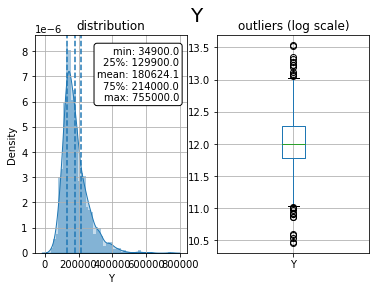

In [89]:
#From https://towardsdatascience.com/machine-learning-with-python-regression-complete-tutorial-47268e546cea
x = "Y"
fig, ax = plt.subplots(nrows=1, ncols=2,  sharex=False, sharey=False)
fig.suptitle(x, fontsize=20)
### distribution
ax[0].title.set_text('distribution')
variable = house_sc[x].fillna(house_sc[x].mean())
breaks = np.quantile(variable, q=np.linspace(0, 1, 11))
variable = variable[ (variable > breaks[0]) & (variable < 
                    breaks[10]) ]
sns.distplot(variable, hist=True, kde=True, kde_kws={"shade": True}, ax=ax[0])
des = house_sc[x].describe()
ax[0].axvline(des["25%"], ls='--')
ax[0].axvline(des["mean"], ls='--')
ax[0].axvline(des["75%"], ls='--')
ax[0].grid(True)
des = round(des, 2).apply(lambda x: str(x))
box = '\n'.join(("min: "+des["min"], "25%: "+des["25%"], "mean: "+des["mean"], "75%: "+des["75%"], "max: "+des["max"]))
ax[0].text(0.95, 0.95, box, transform=ax[0].transAxes, fontsize=10, va='top', ha="right", bbox=dict(boxstyle='round', facecolor='white', alpha=1))
### boxplot 
ax[1].title.set_text('outliers (log scale)')
tmp_dtf = pd.DataFrame(house_sc[x])
tmp_dtf[x] = np.log(tmp_dtf[x])
tmp_dtf.boxplot(column=x, ax=ax[1])
plt.show()

In [93]:
np.random.seed(42)
train, test = train_test_split(house_sc, test_size = 0.5)
val, test = train_test_split(test, test_size = 0.5)
X_train = train.drop(columns = ['Y']).values
y_train = train['Y'].values
X_val = val.drop(columns = ['Y']).values
y_val = val['Y'].values
X_test = test.drop(columns = ['Y']).values
y_test = test['Y'].values
X_train.shape

(725, 195)

Random Forest

In [117]:
house_rf = RandomForestRegressor(n_estimators=500, random_state=1, criterion="absolute_error")
house_rf.fit(X_train, y_train)

RandomForestRegressor(criterion='absolute_error', n_estimators=500,
                      random_state=1)

In [118]:
house_rf_test_pred = house_rf.predict(X_test)

In [119]:
## Kpi
print("R2 (explained variance):", round(metrics.r2_score(y_test, house_rf_test_pred), 2))
print("Mean Absolute Perc Error (Σ(|y-pred|/y)/n):", round(np.mean(np.abs((y_test-house_rf_test_pred)/house_rf_test_pred)), 2))
print("Mean Absolute Error (Σ|y-pred|/n):", "{:,.0f}".format(metrics.mean_absolute_error(y_test, house_rf_test_pred)))
print("Root Mean Squared Error (sqrt(Σ(y-pred)^2/n)):", "{:,.0f}".format(np.sqrt(metrics.mean_squared_error(y_test, house_rf_test_pred))))
## residuals
residuals = y_test - house_rf_val_pred
max_error = max(residuals) if abs(max(residuals)) > abs(min(residuals)) else min(residuals)
max_idx = list(residuals).index(max(residuals)) if abs(max(residuals)) > abs(min(residuals)) else list(residuals).index(min(residuals))
max_true, max_pred = y_test[max_idx], house_rf_test_pred[max_idx]
print("Max Error:", "{:,.0f}".format(max_error))

R2 (explained variance): 0.79
Mean Absolute Perc Error (Σ(|y-pred|/y)/n): 0.1
Mean Absolute Error (Σ|y-pred|/n): 19,023
Root Mean Squared Error (sqrt(Σ(y-pred)^2/n)): 36,500
Max Error: 448,315


Boosting

In [126]:
house_boost = GradientBoostingRegressor(n_estimators=750, learning_rate=0.075,random_state=1, criterion="absolute_error")
house_boost.fit(X_train, y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:1855: FutureWarning: criterion='mae' was deprecated in version 0.24 and will be removed in version 1.1 (renaming of 0.26). The correct way of minimizing the absolute error is to use  loss='absolute_error' instead.
  FutureWarning,


GradientBoostingRegressor(criterion='absolute_error', learning_rate=0.075,
                          n_estimators=750, random_state=1)

In [127]:
house_boost_test_pred = house_boost.predict(X_test)

In [128]:
## Kpi
print("R2 (explained variance):", round(metrics.r2_score(y_test, house_boost_test_pred), 2))
print("Mean Absolute Perc Error (Σ(|y-pred|/y)/n):", round(np.mean(np.abs((y_test-house_boost_test_pred)/house_boost_test_pred)), 2))
print("Mean Absolute Error (Σ|y-pred|/n):", "{:,.0f}".format(metrics.mean_absolute_error(y_test, house_boost_test_pred)))
print("Root Mean Squared Error (sqrt(Σ(y-pred)^2/n)):", "{:,.0f}".format(np.sqrt(metrics.mean_squared_error(y_test, house_boost_test_pred))))
## residuals
residuals = y_test - house_boost_test_pred
max_error = max(residuals) if abs(max(residuals)) > abs(min(residuals)) else min(residuals)
max_idx = list(residuals).index(max(residuals)) if abs(max(residuals)) > abs(min(residuals)) else list(residuals).index(min(residuals))
max_true, max_pred = y_test[max_idx], house_boost_test_pred[max_idx]
print("Max Error:", "{:,.0f}".format(max_error))

R2 (explained variance): 0.72
Mean Absolute Perc Error (Σ(|y-pred|/y)/n): 0.09
Mean Absolute Error (Σ|y-pred|/n): 17,507
Root Mean Squared Error (sqrt(Σ(y-pred)^2/n)): 41,834
Max Error: -503,771
